In [ ]:
#falta fazer o modelo multinivel do segundo dataset (forest fire)

# Importando bibliotecas e dependências

In [1]:
!pip install ucimlrepo

In [2]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import numpy as np
import pytensor.tensor as tt
from sklearn.preprocessing import LabelEncoder as LB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.cluster import KMeans

# Dataset Iris (id=53) - AULA 5

## Importando e tratando dataset

In [3]:
iris = fetch_ucirepo(id=53)

In [4]:
iris = iris.data.original #transforma em dataframe

In [5]:
#localizando os valores únicos da coluna "class"
valores_unicos = iris['class'].unique()
valores_unicos

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [6]:
#excluindo a classe "Iris-virginica" da coluna "class"
iris_filtrado =  iris[iris[ 'class'] != 'Iris-virginica']

In [7]:
#substituindo categorias por valores numéricos
iris_filtrado['class'] = iris_filtrado['class'].replace({'Iris-setosa':0,'Iris-versicolor':1})

<ipython-input-7-e36e0a384b96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris_filtrado['class'] = iris_filtrado['class'].replace({'Iris-setosa':0,'Iris-versicolor':1})


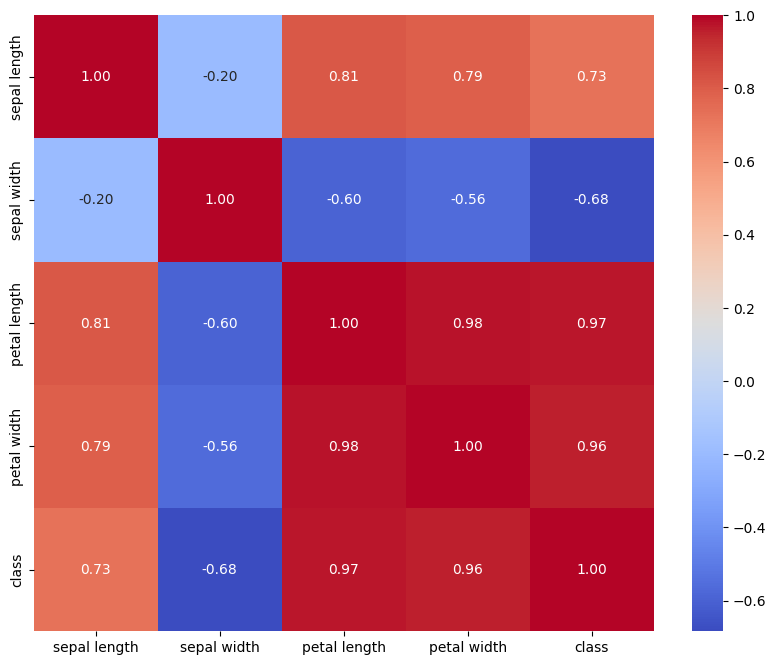

In [8]:
#plotando gráfico de correlação
plt.figure(figsize=(10,8))
sns.heatmap(iris_filtrado.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

#apesar das variaveis estarem altamento correlacionadas entre si, iremos usar todas, pois o dataset tem poucas linhas e colunas

In [9]:
#atribuindo o nome das variáveis independentes a um dicionário com chave chamada "features"
coords = {
    'features': ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
}

In [10]:
#separando features(variaveis independentes) e target(variavel dependente)
X_f = iris_filtrado.iloc[:, 0:4] #features
y = iris_filtrado['class'] #target

In [11]:
#separando dataset entre amostras de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_f, y, test_size=0.3)

## Preditiva a Priori

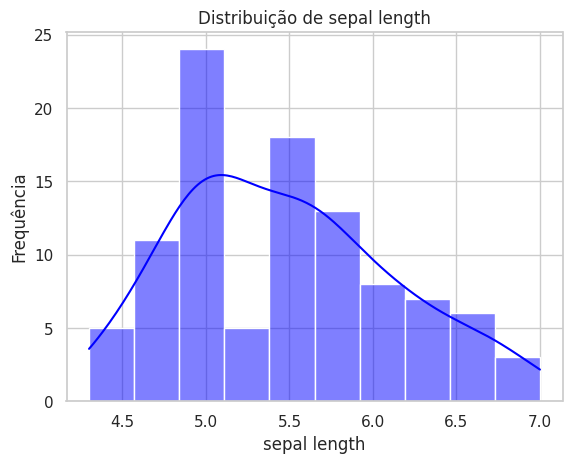

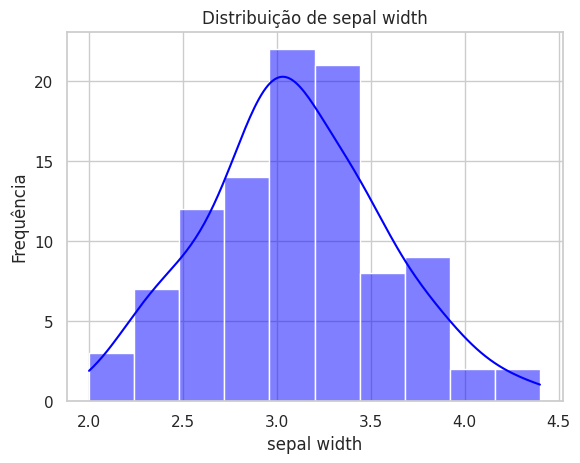

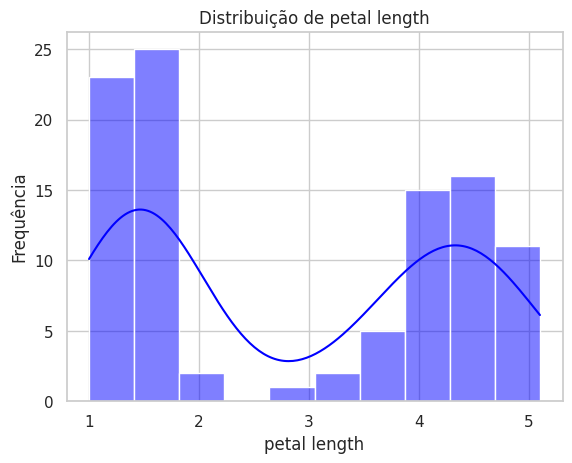

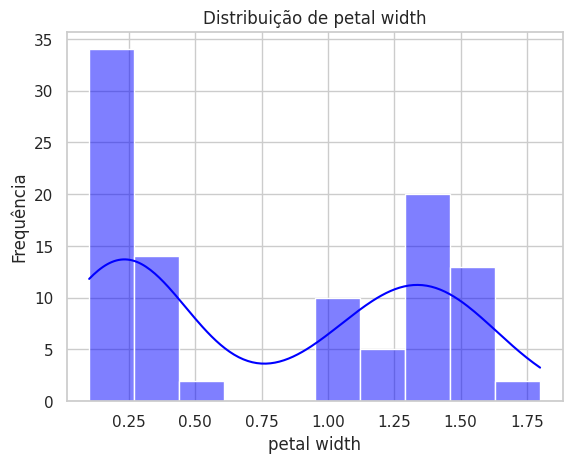

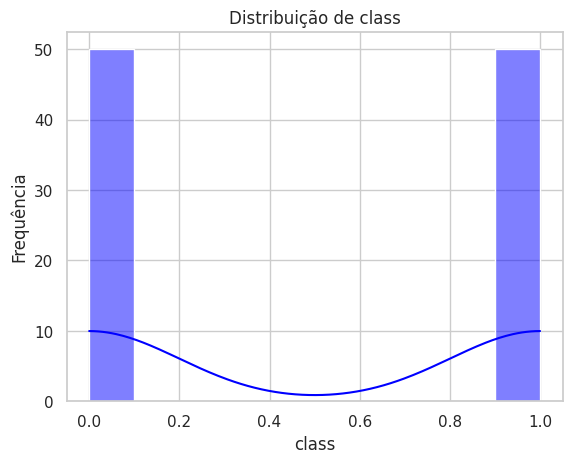

In [12]:
#plotando a distribuição de todas as variáveis
#aqui podemos escolher as distribuições mais adequadas pro modelo
#lembrar que a ultima coluna são as classes da variável resposta, que é binaria
sns.set(style="whitegrid")

for column in iris_filtrado.columns:
    plt.figure()
    sns.histplot(iris_filtrado[column], bins=10, kde=True, color='blue', alpha=0.5)
    plt.title(f'Distribuição de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.show()

In [13]:
#aqui conseguimos colher parametros para as distribuições do modelo
iris_filtrado.describe()

,sepal length,sepal width,petal length,petal width,class
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,5.471000,3.094000,2.862000,0.785000,0.500000
std,0.641698,0.476057,1.448565,0.566288,0.502519
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.000000,2.800000,1.500000,0.200000,0.000000
50%,5.400000,3.050000,2.450000,0.800000,0.500000
75%,5.900000,3.400000,4.325000,1.300000,1.000000
max,7.000000,4.400000,5.100000,1.800000,1.000000


## Modelo 1 - Regressão de Ridge

In [14]:
with pm.Model(coords=coords) as model_1:
  betas = pm.Normal("beta",0,1,dims="features")
  alpha = pm.Normal("alpha",0,1)

  X = [
    pm.MutableData("X_"+column,X_train[column].values)
    for column in X_train.columns if np.issubdtype(X_f[column].dtype, np.number)
  ]

  y = pm.MutableData("y",y_train)

  mu = alpha + tt.dot(betas,X)
  likelihood = pm.Bernoulli("likelihood",pm.math.invlogit(mu),observed=y)

/usr/local/lib/python3.10/dist-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [15]:
#aqui usaremos somente o pm.sample para criar um amostra com os parametros que passamos para o modelo
#pm.sample direto pois a amostra é pequena
#caso contrário, poderiamos usar o pm.fit para ajustar a aproximação dos parâmetros que inserimos
with model_1:
  trace = pm.sample(10000)

Output()

Output()

In [16]:
#visualizando as estatísticas da amostra (r_rat adequado)
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.285,0.979,-2.218,1.506,0.009,0.008,10814.0,10679.0,1.0
beta[sepal_length],-0.383,0.585,-1.493,0.716,0.007,0.005,6623.0,8497.0,1.0
beta[sepal_width],-1.477,0.759,-2.910,-0.054,0.009,0.006,7306.0,9012.0,1.0
beta[petal_length],2.279,0.631,1.065,3.425,0.007,0.005,7971.0,9292.0,1.0
beta[petal_width],0.983,0.939,-0.770,2.770,0.009,0.007,9968.0,9941.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

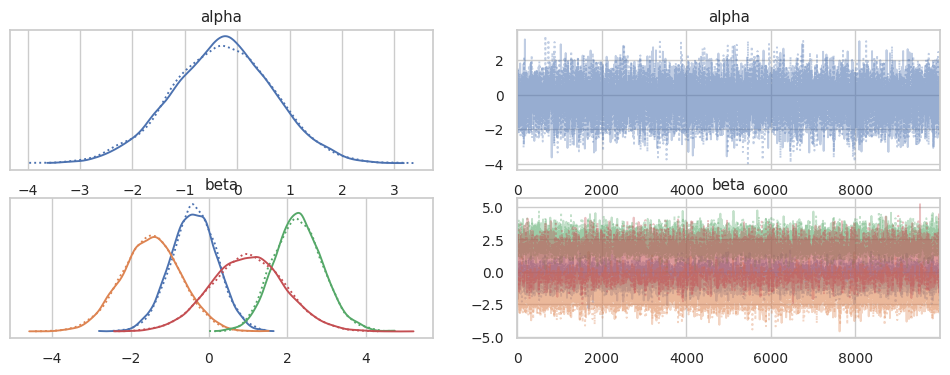

In [17]:
#gráficos das distribuições da amostra
az.plot_trace(trace)

In [18]:
#criando um dicionário que a chave carregará o nome de XNomeDaFeature e os valores de cada feature(variavel)
vars = {"X_"+column : X_test[column].values
    for column in X_test.columns if np.issubdtype(X_test[column].dtype, np.number)}
vars["y"] = y_test

In [19]:
#aplicando a previsão do modelo na amostra a posteriori
with model_1:
  pm.set_data(vars)
  trace_post = pm.sample_posterior_predictive(trace)

Output()

In [20]:
#tirando a media da previsão do modelo no likelihood(observado)
mean_likelihood = trace_post.posterior_predictive['likelihood'].mean(dim=['chain', 'draw'])
#classificando as previsões
binary_predictions = (mean_likelihood > 0.5).astype(int)

In [21]:
#criando um dataframe que receberá uma coluna com os valores de predição e outra com valores de 1=erro e 0=acerto
abs_diff = np.abs(y_test - binary_predictions)

df = pd.DataFrame({
    'sepal length': X_test["sepal length"],
    'y_test': y_test,
    'binary_predictions': binary_predictions,
    'abs_diff': abs_diff
})

In [22]:
#calculando a acurácia
errors = df["abs_diff"].sum()
acc = (len(df)-errors)/len(df)
print(f"Acuracia: {acc:.4f}")
print(f"Erros: {errors}")

Acuracia: 1.0000
Erros: 0


In [23]:
#A acurácia pode não ser a melhor métrica para modelos de classificação, principalmente quando a amostra é desbalanceada
#Por isso, outras formas de se metrificar modelos é através das técnicas de precisão, recall e f1-score

precision = precision_score(y_test, binary_predictions)

recall = recall_score(y_test, binary_predictions)

f1 = f1_score(y_test, binary_predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


# Dataset Forest Fire (id=62) - AULAS 1-4

In [24]:
forest = fetch_ucirepo(id=162)

## Importando e tratando o dataset

In [25]:
forest = forest.data.original

In [26]:
enconder = LB()

# Criar um codificador para a coluna 'month'
encoder_month = LB()
forest['month'] = encoder_month.fit_transform(forest['month'])

# Criar um codificador para a coluna 'day'
encoder_day = LB()
forest['day'] = encoder_day.fit_transform(forest['day'])

In [27]:
forest_X = forest.drop(columns=['X','Y','area'])

In [28]:
forest_y = forest['area']

## Preditiva a Priori

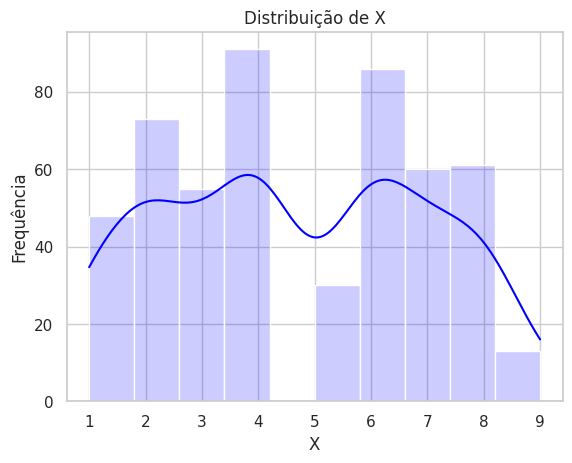

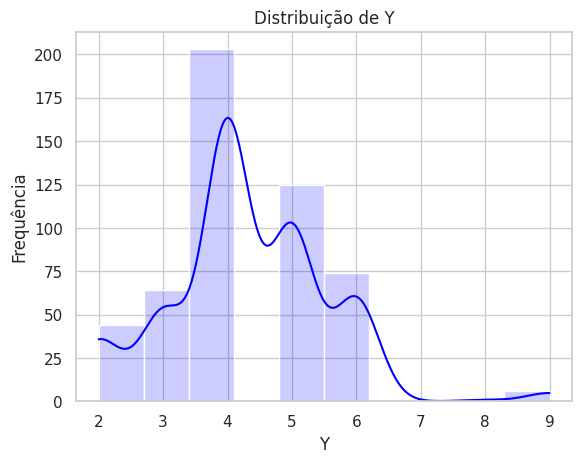

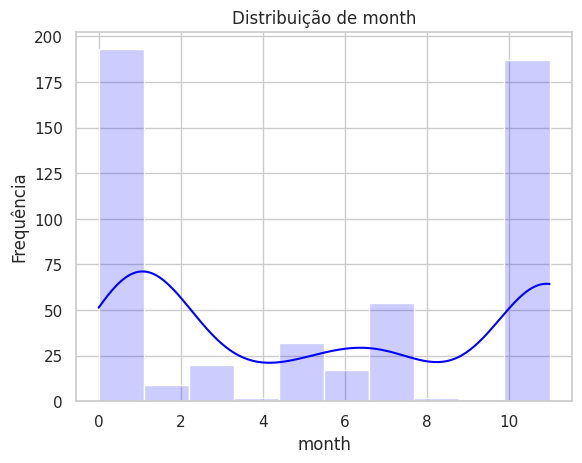

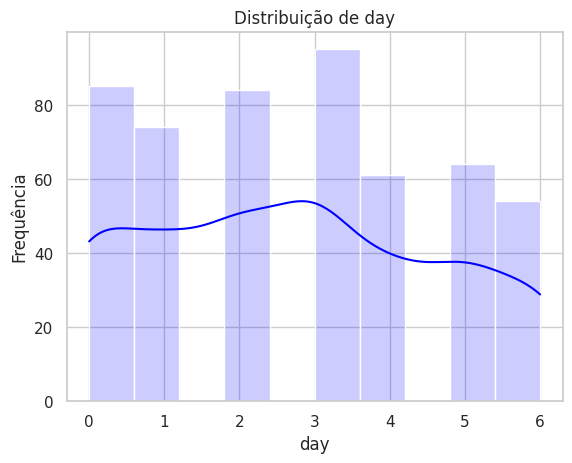

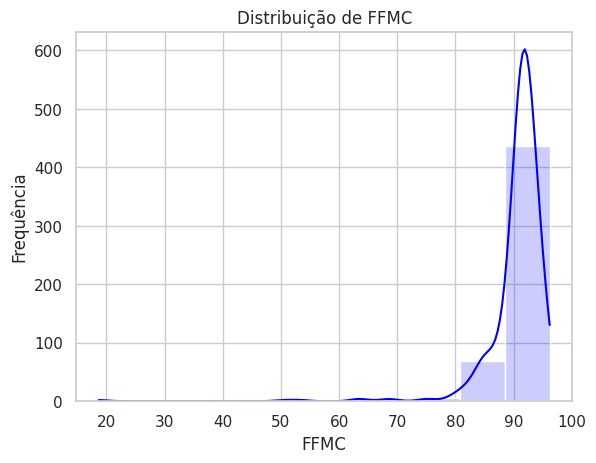

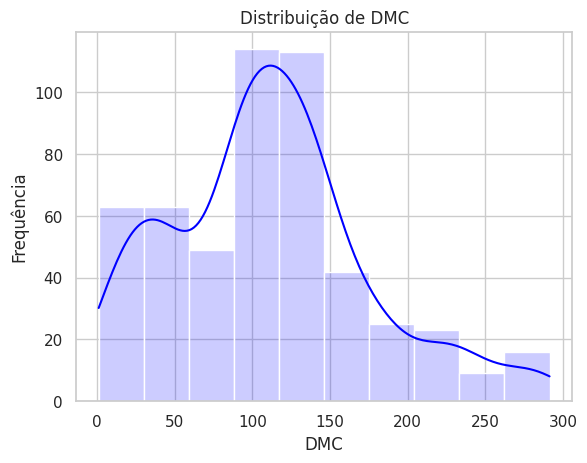

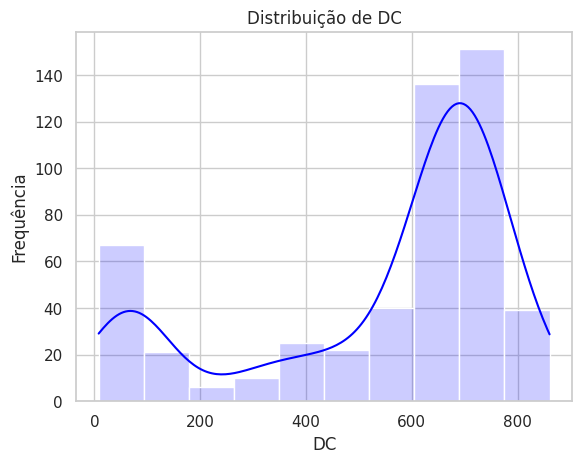

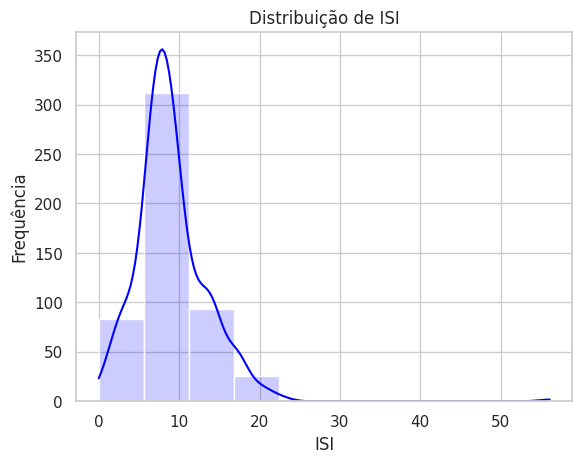

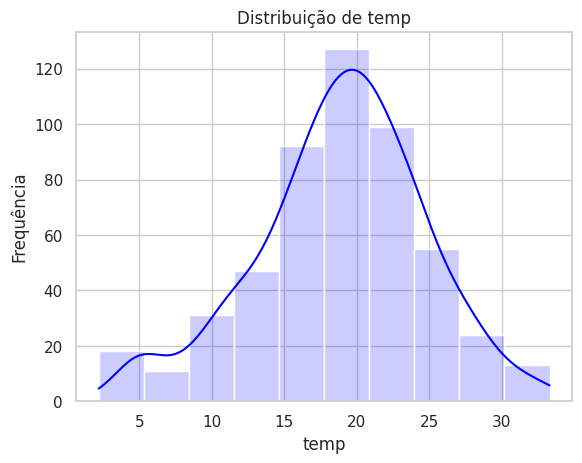

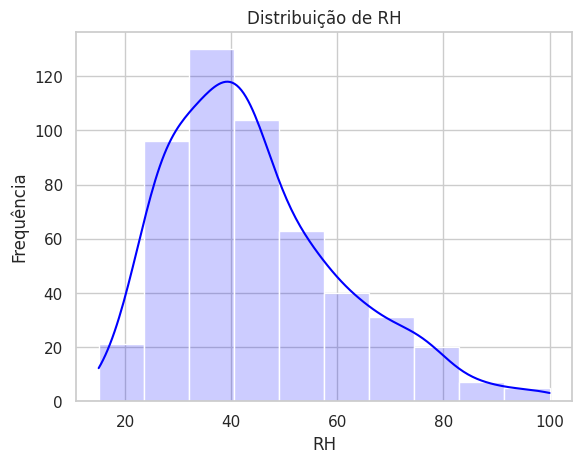

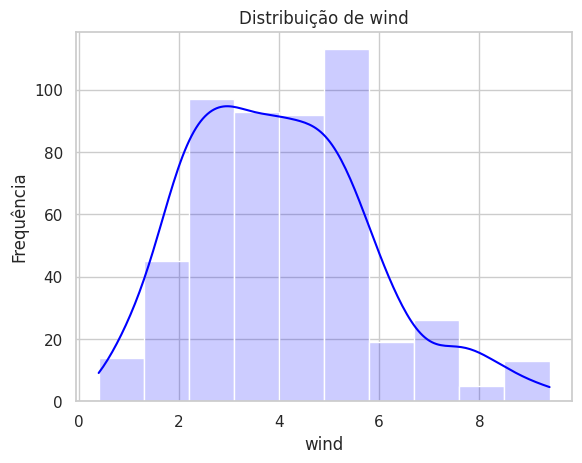

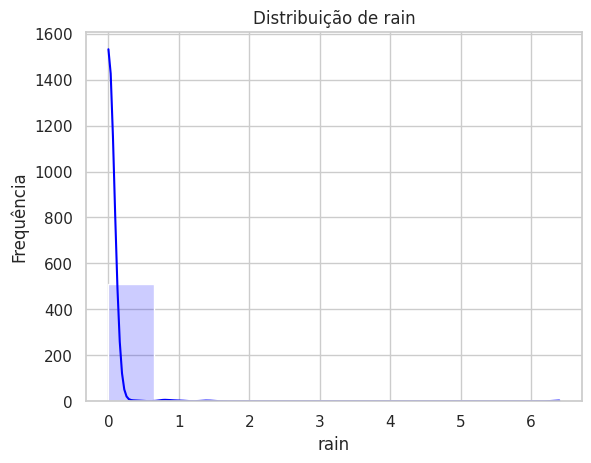

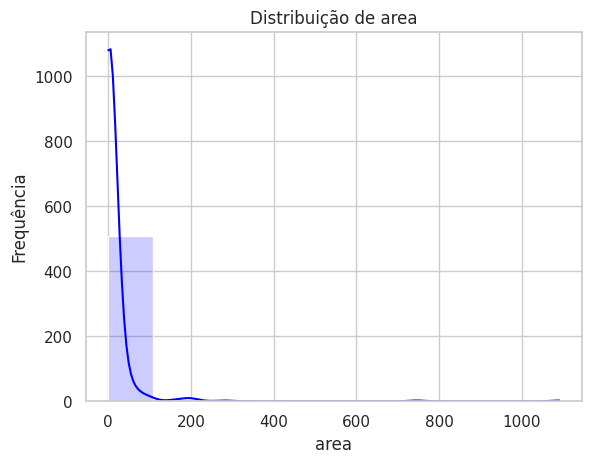

In [29]:
#plotando a distribuição de todas as variáveis
#aqui podemos escolher as distribuições mais adequadas pro modelo
#lembrar que a ultima coluna são as classes da variável resposta, que é binaria
sns.set(style="whitegrid")

for column in forest.columns:
    plt.figure()
    sns.histplot(forest[column], bins=10, kde=True, color='blue', alpha=0.2)
    plt.title(f'Distribuição de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.show()

In [30]:
#aqui conseguimos colher parametros para as distribuições do modelo
forest.describe()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,5.758221,2.736944,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,4.373275,1.925061,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,0.000000,0.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,1.000000,1.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,6.000000,3.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,11.000000,4.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,11.000000,6.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


## Normalizando os dados (nao precisa, se fizermos a preditiva a priori)

In [33]:
scaler = StandardScaler()

In [35]:
#se fizermos a preditiva a priori no começo e colhermos bons parametros pro no modelo, não precisa normalizar os dados
X_normalizado = scaler.fit_transform(forest_X)

In [36]:
X_normalizado = pd.DataFrame(X_normalizado,columns=forest_X.columns)

## Prever a área

### Modelo 1 -regressão multilinear

In [38]:
coords = {
    'features': ['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain']
}

In [39]:
with pm.Model(coords=coords) as reg_model1:
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 1, dims='features')

    mu = a + tt.dot(X_normalizado, b)

    eps = pm.HalfNormal("eps", 1)

    likelihood = pm.Normal("y_obs", mu, eps, observed=forest_y)


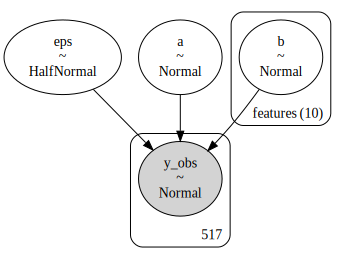

In [40]:
pm.model_to_graphviz(reg_model1)

In [41]:
with reg_model1:
  trace = pm.sample()

Output()

Output()

In [42]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.844,0.842,2.351,5.539,0.015,0.011,3340.0,1419.0,1.0
b[month],0.627,0.864,-1.084,2.181,0.016,0.016,2974.0,1620.0,1.0
b[day],0.228,0.810,-1.276,1.744,0.016,0.017,2604.0,1607.0,1.0
b[FFMC],0.311,0.854,-1.309,1.876,0.017,0.017,2472.0,1586.0,1.0
b[DMC],1.131,0.861,-0.476,2.714,0.017,0.014,2609.0,1489.0,1.0
b[DC],0.452,0.896,-1.171,2.151,0.016,0.016,3186.0,1457.0,1.0
b[ISI],-0.240,0.882,-1.941,1.393,0.015,0.018,3491.0,1539.0,1.0
b[temp],1.460,0.866,-0.299,2.926,0.016,0.013,2855.0,1504.0,1.0
b[RH],-1.187,0.879,-2.792,0.433,0.017,0.014,2749.0,1855.0,1.0
b[wind],0.478,0.849,-1.042,2.154,0.017,0.016,2463.0,1482.0,1.0


array([[<Axes: title={'center': 'a'}>,
        <Axes: title={'center': 'b\nmonth'}>,
        <Axes: title={'center': 'b\nday'}>],
       [<Axes: title={'center': 'b\nFFMC'}>,
        <Axes: title={'center': 'b\nDMC'}>,
        <Axes: title={'center': 'b\nDC'}>],
       [<Axes: title={'center': 'b\nISI'}>,
        <Axes: title={'center': 'b\ntemp'}>,
        <Axes: title={'center': 'b\nRH'}>],
       [<Axes: title={'center': 'b\nwind'}>,
        <Axes: title={'center': 'b\nrain'}>,
        <Axes: title={'center': 'eps'}>]], dtype=object)

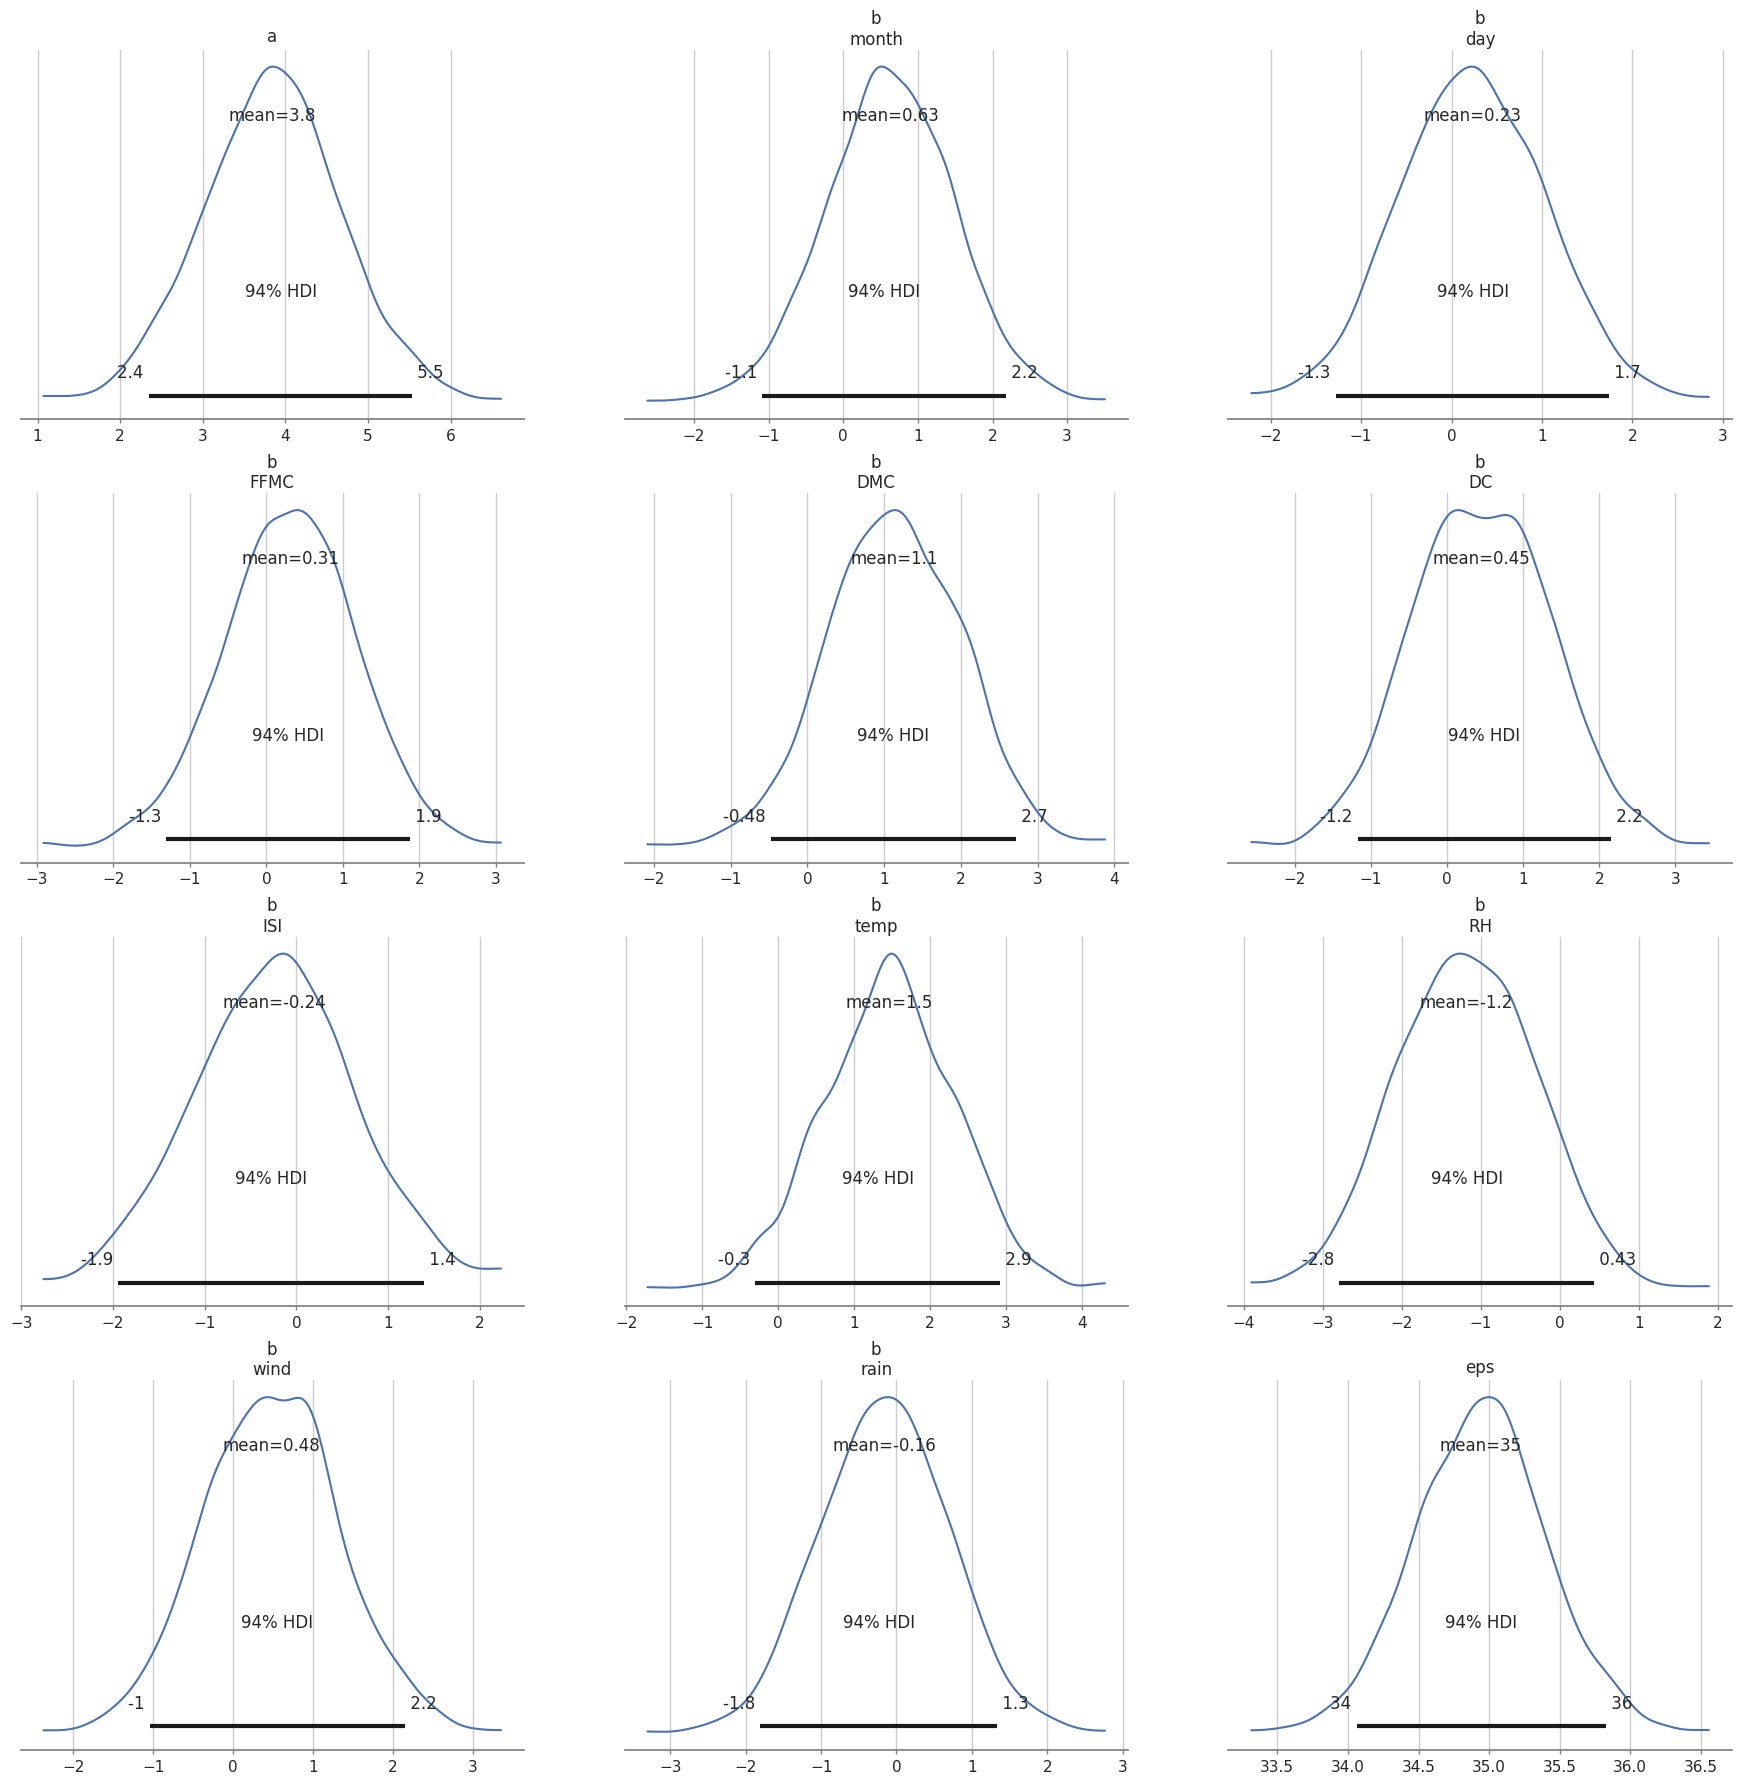

In [43]:
az.plot_posterior(trace)

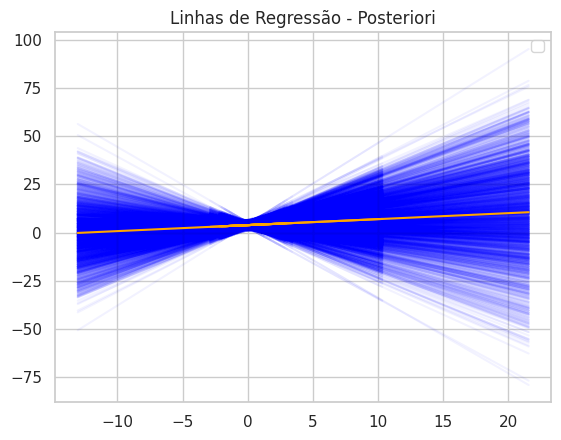

In [44]:
a_samples = trace.posterior["a"].values.flatten()
b_samples = trace.posterior["b"].values.flatten()
t_values = np.linspace(X_normalizado.min(), X_normalizado.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange")

#plt.scatter(t, obs, color="red", label="Observed Data", alpha=0.5)

plt.xlabel("")
plt.ylabel("")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()


### Modelo 2 - regressão de lasso

In [45]:
with pm.Model(coords=coords) as reg_lasso:
    a = pm.Laplace("a", 0, 1)
    b = pm.Laplace("b", 0, 1, dims='features')

    mu = a + tt.dot(X_normalizado, b)

    eps = pm.HalfNormal("eps", 1)

    likelihood = pm.Normal("y_obs", mu, eps, observed=forest_y)

In [46]:
with reg_lasso:
  trace_lasso = pm.sample()

Output()

Output()

In [47]:
pm.summary(trace_lasso)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,10.537,1.499,7.919,13.441,0.029,0.021,2577.0,1293.0,1.0
b[month],0.894,1.124,-1.016,3.152,0.027,0.026,2024.0,1131.0,1.0
b[day],0.205,0.964,-1.592,2.086,0.029,0.034,1294.0,797.0,1.0
b[FFMC],0.179,0.998,-1.705,2.211,0.022,0.024,2116.0,1337.0,1.0
b[DMC],1.789,1.467,-0.676,4.438,0.041,0.033,1430.0,1118.0,1.0
b[DC],0.209,1.025,-1.633,2.305,0.027,0.028,1584.0,1029.0,1.0
b[ISI],-0.477,0.996,-2.453,1.293,0.021,0.022,2431.0,1068.0,1.0
b[temp],2.588,1.734,-0.368,5.776,0.048,0.035,1366.0,1457.0,1.0
b[RH],-1.622,1.379,-4.338,0.565,0.036,0.027,1611.0,1338.0,1.0
b[wind],0.727,1.097,-1.272,2.858,0.029,0.032,1644.0,704.0,1.0


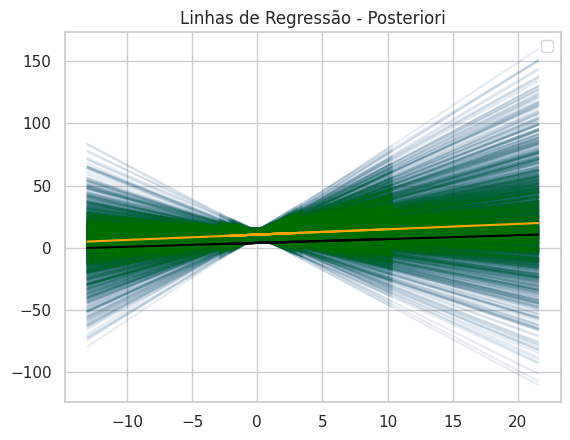

In [48]:
a_samples = trace_lasso.posterior["a"].values.flatten()
b_samples = trace_lasso.posterior["b"].values.flatten()

a_samples_r = trace.posterior["a"].values.flatten()
b_samples_r = trace.posterior["b"].values.flatten()

t_values = np.linspace(X_normalizado.min(), X_normalizado.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

for a_sample_r, b_sample_r in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample_r + b_sample_r * t_values, color="green", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange" )

mean_a_r = a_samples_r.mean()
mean_b_r = b_samples_r.mean()
plt.plot(t_values, mean_a_r + mean_b_r * t_values, color="black" )

#plt.scatter(t, obs_norm, color="red", alpha=0.5)

plt.xlabel("")
plt.ylabel("")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()


### Modelo 3 - regressao robusta

In [49]:
with pm.Model(coords=coords) as reg_robust:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1, dims='features')

  mu = a + tt.dot(X_normalizado, b)

  df = pm.Exponential("df",1)

  likelihood = pm.StudentT("y_obs",nu=df,mu=mu,observed=forest_y)

In [50]:
with reg_robust:
  trace_robust = pm.sample()

Output()

Output()

In [51]:
pm.summary(trace_robust)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.183,0.045,0.093,0.261,0.001,0.001,1577.0,1166.0,1.0
b[month],-0.024,0.052,-0.119,0.077,0.001,0.001,1378.0,1440.0,1.0
b[day],0.007,0.044,-0.070,0.093,0.001,0.001,1924.0,1289.0,1.0
b[FFMC],0.015,0.049,-0.078,0.104,0.001,0.001,1892.0,1288.0,1.0
b[DMC],-0.050,0.072,-0.190,0.076,0.002,0.001,1554.0,1281.0,1.0
b[DC],0.044,0.070,-0.085,0.172,0.002,0.001,1395.0,1398.0,1.0
b[ISI],0.002,0.053,-0.100,0.102,0.001,0.001,1672.0,1245.0,1.0
b[temp],0.049,0.083,-0.114,0.197,0.003,0.002,1027.0,1249.0,1.0
b[RH],0.019,0.062,-0.099,0.130,0.002,0.001,1121.0,1246.0,1.0
b[wind],0.014,0.048,-0.079,0.098,0.001,0.001,1712.0,1299.0,1.0


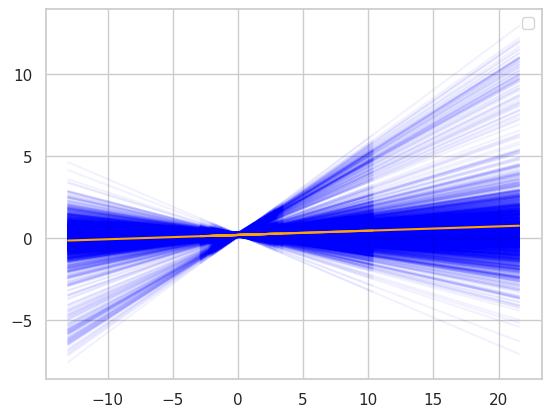

In [52]:
a_samples = trace_robust.posterior["a"].values.flatten()
b_samples = trace_robust.posterior["b"].values.flatten()
t_values = np.linspace(X_normalizado.min(), X_normalizado.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange", )

#plt.scatter(t, obs_norm, color="red", alpha=0.5)

plt.xlabel("")
plt.ylabel("")
plt.title("")
plt.legend()
plt.show()

In [53]:
with reg_robust:
    trace_post_rob = pm.sample_posterior_predictive(trace_robust)

Output()

array([<Axes: xlabel='y_obs'>], dtype=object)

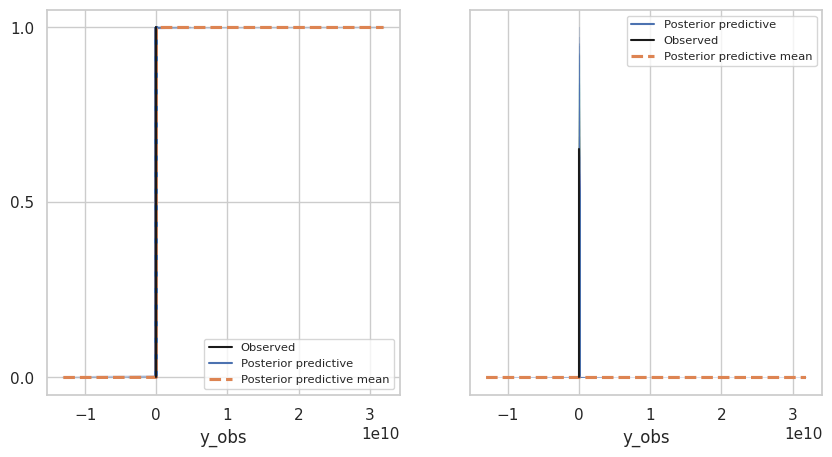

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(trace_post_rob, group='posterior', kind='cumulative', ax=axes[0])
az.plot_ppc(trace_post_rob, group='posterior', ax=axes[1])

### Log-likelihood

In [55]:

with reg_model1:
    pm.compute_log_likelihood(trace)

with reg_lasso:
    pm.compute_log_likelihood(trace_lasso)

with reg_robust:
    pm.compute_log_likelihood(trace_robust)

Output()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

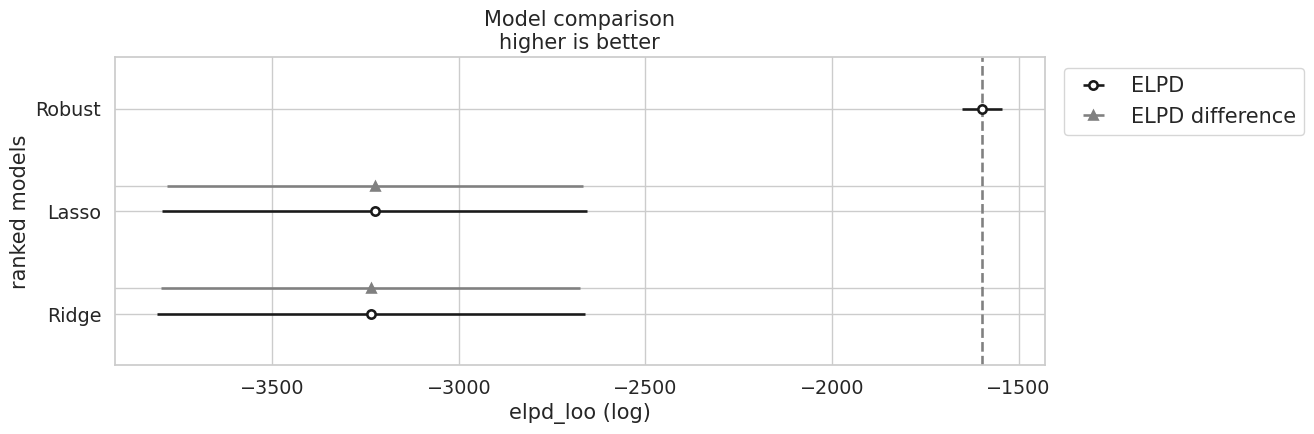

In [56]:
model_compare = az.compare(
    {
        "Ridge": trace,
        "Lasso": trace_lasso,
        "Robust": trace_robust
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)


In [57]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Robust,0,-1597.691367,6.183484,0.000000,1.0,53.831594,0.000000,False,log
Lasso,1,-3225.384175,104.356684,1627.692808,0.0,569.631875,557.274517,True,log
Ridge,2,-3236.326675,105.577066,1638.635308,0.0,573.471022,560.990035,True,log


### Modelo 4 - regressão multinivel - (ARRUMAR)


In [58]:
scaler = StandardScaler()
forest_normalizado = scaler.fit_transform(forest)
forest_normalizado = pd.DataFrame(forest_normalizado, columns=forest.columns)

In [59]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(forest_normalizado)

forest_normalizado['cluster'] = clusters
forest_normalizado

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,cluster
0,1.008313,0.569860,0.284222,-1.423121,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.202020,3
1,1.008313,-0.244001,0.970871,1.176715,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.202020,1
2,1.008313,-0.244001,0.970871,-0.383187,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.202020,1
3,1.440925,1.383722,0.284222,-1.423121,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.202020,3
4,1.440925,1.383722,0.284222,0.136781,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.202020,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,-0.289524,-1.057862,-1.089076,0.136781,-1.640083,-0.846648,0.474768,-1.563460,1.536084,-0.753800,-0.736124,-0.073268,-0.100753,2
513,-1.154748,-0.244001,-1.089076,0.136781,-1.640083,-0.846648,0.474768,-1.563460,0.519019,1.638592,0.995798,-0.073268,0.651674,3
514,1.008313,-0.244001,-1.089076,0.136781,-1.640083,-0.846648,0.474768,-1.563460,0.398350,1.577248,1.498614,-0.073268,-0.026532,3
515,-1.587360,-0.244001,-1.089076,-0.383187,0.680957,0.549003,0.269382,0.500176,1.156839,-0.140366,-0.009834,-0.073268,-0.202020,2


In [60]:
coords2 = {
    'features': ['X','Y','month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain','cluster']
}

In [61]:
forest_normalizado_features = forest_normalizado.drop(columns=['area'])
forest_normalizado_target = forest_normalizado['area'].values

In [62]:
#TA DANDO ERRO

#ajustes: deixar só X e Y pra clusterizar e nao faz sentido normalizado mes e dia

# with pm.Model(coords=coords2) as model_4:
#   betas = pm.Normal("beta",0,1,dims="features")
#   alpha = pm.Normal("alpha",0,1,shape=5)

#   X = [
#     pm.MutableData("X_"+column,forest_normalizado_features)
#     for column in forest_normalizado_features.columns
#   ]

#   y = pm.MutableData("y",forest_normalizado_target)

#   mu = alpha[X[0:12]] + tt.dot(betas,forest_normalizado_features)
#   likelihood = pm.Normal("likelihood",pm.math.invlogit(mu),observed=y)

In [63]:
# with model_4:
#   trace_4 = pm.sample()